In [1]:
# Imports

from autodisk import *
from autodisk_mtc import *
from mtc_helpers import *

In [2]:
# Input and sanitize 4D-STEM file.

data_name = 'pdpt_x64_y64.raw'
data = readData(data_name)
data = preProcess(data)
img_h,img_w,diff_pat_h,diff_pat_w = data.shape

In [3]:
# Determine center disk position and radius from sum pattern

avg_pattern = generateAvgPattern(data)
center_disk,r = ctrRadiusIni(avg_pattern)


In [4]:
# Generate kernel, then cross-correlate

kernel = generateKernel(avg_pattern,center_disk,r,0.7,2)
cros_map = crossCorr(avg_pattern,kernel)

[[ 64.  64.]
 [ 61.  40.]
 [ 87.  69.]
 [ 37.  33.]
 [109.  51.]
 [ 58.  15.]
 [ 40.  58.]
 [ 82.  21.]
 [ 91.  94.]
 [106.  26.]
 [ 67.  88.]
 [112.  76.]
 [ 34.   9.]
 [ 84.  45.]
 [ 16.  52.]
 [ 13.  28.]
 [ 43.  82.]
 [115. 100.]
 [119.   3.]
 [ 19.  77.]
 [ 10.   3.]
 [ 70. 113.]
 [ 46. 107.]
 [ 22. 102.]
 [ 94. 119.]]


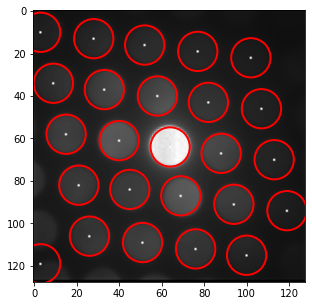

In [5]:
# Detect disks and refine positions with radial gradient maximization

detected_disks = ctrDet(cros_map, r, kernel, 10, 5)
refined_disks_weights = radGradMax(avg_pattern, detected_disks, r,ra=4)
refined_disks_list = refined_disks_weights[:,:2]
print(refined_disks_list)
drawCircles(np.sqrt(avg_pattern),refined_disks_list,r)

In [6]:
# Detect the angle of rotation to put disks along a horizontal axis
angle, refined_disks_weights = detAng(refined_disks_weights,center_disk,r)

print('Estimated rotation angle: ',angle,'(deg)')

# Generate the coordinate of disks in the new coordinate system 
rotated_refined_disks_weights = rotCtr(avg_pattern,refined_disks_weights,angle) 

Estimated rotation angle:  6.905181511707201 (deg)


In [7]:
# Fit the rotated disks to a set of two basis vectors
vec_a_rotated,vec_b_rotated,rotated_refined_disks_weights, middle_row_disks,angle_delta = latFit(avg_pattern,rotated_refined_disks_weights,r)

print('Two lattice vectors: vector_a--[',vec_a_rotated[0],vec_a_rotated[1], '] and vector_b--[',vec_b_rotated[0],vec_b_rotated[1],']')

Two lattice vectors: vector_a--[ 0.0 24.73812676453156 ] and vector_b--[ 22.566088004645977 8.711847564290212 ]


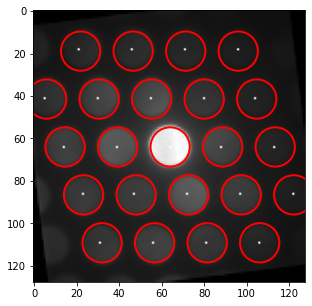

In [8]:
generated_lattice_pts = genLat(avg_pattern, vec_a_rotated, vec_b_rotated, middle_row_disks,r)
generated_lattice_pts = delArti(generated_lattice_pts,rotated_refined_disks_weights,r)
rotated_pattern = rotImg(avg_pattern, angle+angle_delta, center_disk)
vec_a, vec_b= latBack(vec_a_rotated, vec_b_rotated, angle)
drawDisks(np.sqrt(rotated_pattern),generated_lattice_pts,r)

In [12]:
### working on simple parallelization


# import multiprocessing as mp

# lat_par_pooled = np.zeros((img_h,img_w,2,2),dtype = float)
# num_threads = 8
# lock = mp.Lock()
# with mp.Pool(processes=mp.cpu_count()) as pool:
#     pool.apply_async(process, args = (i, ), callback = callback)
# pool.close()
# pool.join()

lat_par = np.zeros((img_h,img_w,2,2),dtype = float)
start = time.perf_counter()
percent_complete = 0
time_remaining = 0
avg_time = [0,0]

for row_idx in range (img_h):
    for col_idx in range (img_w):
        result = process(data,row_idx,col_idx,kernel,r,center_disk,angle)
        lat_par[row_idx,col_idx,0,:] = result[0]
        lat_par[row_idx,col_idx,1,:] = result[1]
        avg_time = timeToFinish(img_h,img_w,avg_time,current_time=time.perf_counter()-start)          
                

    print('Processed {} out of {} rows of patterns.'.format(row_idx+1,img_h))
    
print('-------------------Process Finished-------------------')

Processed 64 out of 64 rows of patterns.
-------------------Process Finished-------------------


In [13]:
lat_fil = latDist(lat_par,vec_a,vec_b)
st_xx,st_yy,st_xy,st_yx,tha_ang = calcStrain(lat_fil, vec_a, vec_b)

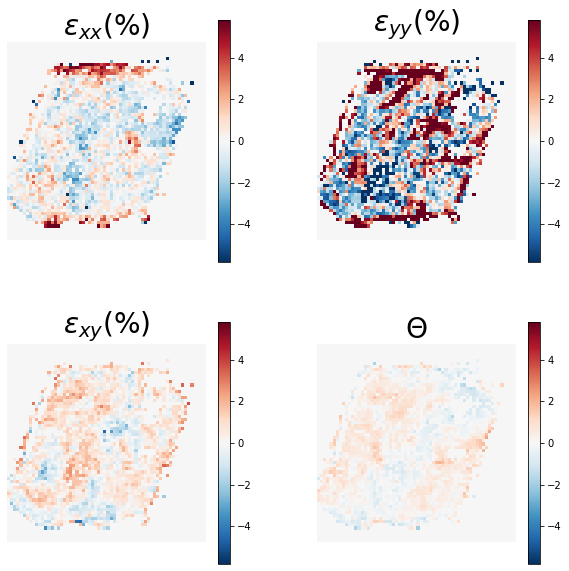

In [14]:
rdbu = plt.cm.get_cmap('RdBu')
cmap_re = rdbu.reversed()
  
input_min=-0.058
input_max=0.058

l_min = input_min*100
l_max = input_max*100

titles = ["$\epsilon_{xx}(\%)$","$\epsilon_{yy}(\%)$","$\epsilon_{xy}(\%)$","$\Theta$"]
comb = [st_xx,st_yy,st_xy,tha_ang]

fig,axs = plt.subplots(2,2,figsize = (10,10))
i=0
for row in range (2):
    for col in range (2):
        if row==1 and col==1:
            ax = axs[row,col]
            pcm = ax.imshow(comb[i],cmap=cmap_re,vmin=l_min,vmax=l_max)
            ax.set_title(titles[i],fontsize=28)
            ax.set_axis_off()
            fig.colorbar(pcm,ax=ax)
            i +=1
        else:    
            ax = axs[row,col]
            pcm = ax.imshow(comb[i]*100,cmap=cmap_re,vmin=l_min,vmax=l_max)
            ax.set_title(titles[i],fontsize=28)
            ax.set_axis_off()
            fig.colorbar(pcm,ax=ax)
            i +=1
       
plt.subplots_adjust(wspace=0.25,hspace=0.25)
plt.show()